# Universidade Federal do Rio Grande do Norte
## Programa de Pós-graduação em Engenharia Elétrica e de Computação
### Course: Tópicos Especiais C
### Professor: Ivanovitch Silva
### Students: 

* Aguinaldo Bezerra Batista Júnior
* Pedro Klisley Ferreira da Silva
* Ycaro Ravel Dantas

#### Activity: Task 2, Project 2
#### Subject: Analyzing Uber Rides
#### Objectives: Colect data and perform data analysis over Uber rides, using the Uber API and following guidance and hints in the professor's notebook
#### Dataset: uber-eta.csv

In [107]:
# Loading the necessary libraries
import os
import folium
import json
import pandas as pd
from branca.colormap import linear
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
from numpy import random
from mpl_toolkits.basemap import Basemap
bm = Basemap(resolution='i')
import requests
import time
import datetime

In [108]:
# Loadion the uber client libs and start a session
from uber_rides.session import Session
from uber_rides.client import UberRidesClient

# Server token obtained by registering in the Uber developer site
session = Session(server_token='LNWgPcxsbiHlLPAHjNMqEN7BlAeyWURlqhdce6uQ')
uber_client = UberRidesClient(session)


### 1 Importing Geojson files from overpass-turbo project

First off, professor supplied a json format list containing coordinates of the neighboorhoods in the city of Natal/RN, Brazil and explained how it was obtained:

Source: http://overpass-turbo.eu/

Query to [Natal neighborhoods](http://wiki.openstreetmap.org/wiki/Natal#Bairros):
>```python
[out:json][timeout:25];
{{geocodeArea:Natal RN Brasil}}->.searchArea;
(
  relation["admin_level"="10"](area.searchArea);
);
out body;
>;
out skel qt;
```

The supplied list has to be loaded in an appropriate way:

In [109]:
# import geojson file about natal neighborhood
natal_neigh = os.path.join('geojson', 'natal.geojson')

# load the data and use 'UTF-8'encoding
geo_json_natal = json.load(open(natal_neigh,encoding='UTF-8'))

We can list the neighborhoods and figure out better our city:

In [110]:
neighborhood = []
# list all neighborhoods
for neigh in geo_json_natal['features']:
        neighborhood.append(neigh['properties']['name'])

len(neighborhood)

36

With the neighborhoods coordinates loaded, we may choose some random points inside the neighborhood's polygon to start the study. To make a criterious choice of the random points inside the polygons, we have developed two helper functions. Function on_water() uses the "On Water API" (https://onwater.io) to determine if a point is "on water" or not. Function uber_availables() uses the Uber API to check if a valid response is given by the API. The function is_land() of the Basemap library is also used to help in the point selection.

In [111]:
# On Water API client function
def on_water(lat,log):
    lat = str(lat)
    log = str(log)
    api_url="https://api.onwater.io/api/v1/results/"+lat+","+log+"?access_token=NymZ1KAM585N4tVqwrUi"
    try:
        onwater = requests.get(api_url,timeout=10).json()  
    except requests.exceptions.HTTPError as err:
        print(err)
        return False
        pass
    print("On Water")
    print(onwater['water'])
    time.sleep(5)
    return onwater['water']

In [112]:
# Check valid response from Uber API
content_min_length = 50
def uber_available(lat,log):
    product = '65cb1829-9761-40f8-acc6-92d700fe2924'
    wait_time = uber_client.get_pickup_time_estimates(lat,log,product)
    #print(wait_time.headers.get('Content-Length'))
    #print(wait_time.json.get('times')[0]['estimate'])
    if int(wait_time.headers.get('Content-Length')) < content_min_length:
        print("Empty Uber Response")
        return False
    print("Uber Available")
    return True

We came accross a project which maintain geojson data about in-land waters in Brazil: https://marcelopiva.carto.com/tables/bra_water_areas_dcw_1/public/map

So, it was possible to gather coordinates of a big River in Natal, the Potengi River. With Potengi's bounds in hands we can apprimorate the in-land point check.

In [113]:
# import geojson file about potengi river bounds
potengi = os.path.join('geojson', 'potengi.geojson')

# load the data and use 'UTF-8'encoding
potengi_geojson = json.load(open(potengi,encoding='UTF-8'))

from shapely.geometry import shape, mapping

pontengi_multipoly = shape(potengi_geojson['features'][0]['geometry'])

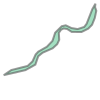

In [114]:
pontengi_multipoly

In [117]:
def potengi(point):

    for poly in pontengi_multipoly:
        polygon = Polygon(poly)
        if polygon.contains(point):
            return True
        else:
            return False

The function generate_random() does the job of generate and select good points.

In [118]:
# return a number of points inside the polygon
# test if there's an Uber API response for them and if they are in land or water
def generate_random(number, polygon, neighborhood):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        pnt = Point(x, y)
        if polygon.contains(pnt):
            if bm.is_land(x,y):
                if not potengi(pnt):
                #if not on_water(y,x):
                    #if uber_available(y,x):
                        list_of_points.append([x,y,neighborhood])
                        counter += 1
    return list_of_points

Thus, it is now possible to define a number of points and generate them:

In [119]:
# Point generation
number_of_points = 3
all_points = []
# search all features
for feature in geo_json_natal['features']:
    # get the name of neighborhood
    neighborhood = feature['properties']['name']
    # take the coordinates (lat,log) of neighborhood
    geom = feature['geometry']['coordinates']
    # create a polygon using all coordinates
    polygon = Polygon(geom[0])
    # return number_of_points by neighborhood as a list [[log,lat],....]
    points = generate_random(number_of_points,polygon, neighborhood)
    all_points.extend(points)

all_points_df = pd.DataFrame(all_points)

filename = 'selected_points-wo_potengi.csv'
all_points_df.to_csv(filename, mode='w', header=True, index=False)

Because the use of Basemap and the online APIs, this point selection process takes too long. So, we have decided to run this process outside this notebook and load the resulting file back here.

In [120]:
# Loading the selected points
all_points_df = pd.read_csv('selected_points-wo_potengi.csv')
all_points = all_points_df.values.tolist()

The Folium library is used to plot the selected poins in the map of Natal

In [121]:
# Create a map object
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=11,
    tiles='Stamen Terrain'
)

# Configure geojson layer
folium.GeoJson(geo_json_natal).add_to(m)

In [122]:
for i,value in enumerate(all_points):
        log, lat, name = value 
        # Draw a small circle
        folium.CircleMarker([lat,log],
                    radius=2,
                    popup='%s %s%d %f %f' % (name, '#', i, lat, log),
                    color='red').add_to(m)
m

After selecting these points, we had to run a data collection procedure for a week. This procedure is basicly to retrieve the ETA (Estimated Time to Arrive) for each selected point from the Uber API (for a given product id, in our case, UberX). To accomplish this, we run the following piece of code:

In [29]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import geohash
import time


from uber_rides.session import Session
from uber_rides.client import UberRidesClient

product = '65cb1829-9761-40f8-acc6-92d700fe2924'

all_points_df = pd.read_csv('selected_points1.csv')
all_points = all_points_df.values.tolist()

session = Session(server_token='LNWgPcxsbiHlLPAHjNMqEN7BlAeyWURlqhdce6uQ')
client = UberRidesClient(session)

uber_eta_df = pd.DataFrame(columns = ['datetime', 'log', 'lat', 'neigh', 'point_hash', 'eta'])


content_min_length = 50
max_rereq = 3
counter = 0
for i,value in enumerate(all_points):
        log, lat, name = value
        
        try:
            wait_time = client.get_pickup_time_estimates(lat,log,product)
            cont_len = wait_time.headers.get('Content-Length')
        except Exception as e:
             print(e.__doc__)
             print (e.message)
             cont_len = 0
        continue
    #print(wait_time.status_code)
    #print(wait_time.json)
    print(cont_len)
    while int(cont_len) < content_min_length:
                time.sleep(5)
        print("Re-requesting...")
        wait_time = client.get_pickup_time_estimates(lat,log,product)
        print(wait_time.headers.get('Content-Length'))
        counter += 1
        if counter >= 3:
                    break
                    print("Giving up after 3 attempts...")

    eta = wait_time.json.get('times')[0]['estimate']
 
    uber_eta_df =  uber_eta_df.append({
                 "datetime": dt.datetime.now(),
                 "log": log,
                 "lat": lat,
                 "neigh": name,
                 "point_hash": geohash.encode(lat,log),
                #"eta": 0
                 "eta": wait_time.json.get('times')[0]['estimate']
                  }, ignore_index=True)
          
        
uber_eta_df.to_csv('uber-eta.csv', mode='a', header=True, index=False)



SyntaxError: Missing parentheses in call to 'print' (<ipython-input-29-f15fe44059ca>, line 34)

This script retrieved data for a week from Uber API. The resulting file will be now loaded....

In [75]:
# import geojson file about natal neighborhood
potengi = os.path.join('geojson', 'potengi.geojson')

# load the data and use 'UTF-8'encoding
potengi_geojson = json.load(open(potengi,encoding='UTF-8'))

In [76]:
potengi_geojson

{'features': [{'geometry': {'coordinates': [[[[-35.208893, -5.783699],
       [-35.217812, -5.788129],
       [-35.22641, -5.788036],
       [-35.230664, -5.78799],
       [-35.236657, -5.784124],
       [-35.241253, -5.783467],
       [-35.244683, -5.7851],
       [-35.247635, -5.789259],
       [-35.247109, -5.798451],
       [-35.249821, -5.804217],
       [-35.255749, -5.809546],
       [-35.269017, -5.815386],
       [-35.27472, -5.820024],
       [-35.278542, -5.831085],
       [-35.291569, -5.838302],
       [-35.32021, -5.844939],
       [-35.310158, -5.838203],
       [-35.288628, -5.832765],
       [-35.282246, -5.826743],
       [-35.278179, -5.81775],
       [-35.274762, -5.814047],
       [-35.263336, -5.80753],
       [-35.256047, -5.799893],
       [-35.2547, -5.795976],
       [-35.252457, -5.789063],
       [-35.243798, -5.780497],
       [-35.23853, -5.77931],
       [-35.230931, -5.782935],
       [-35.222889, -5.784257],
       [-35.214188, -5.781436],
       [-35.2

In [158]:
#feat = potengi_geojson['features']
#geometry = feat[0]['geometry']['coordinates']
#potengi_poly =  Polygon(geometry)

#from osgeo import ogr

#g = ogr.CreateGeometryFromJson(potengi_geojson['features']) 

from shapely.geometry import shape, mapping

from pygeoif import geometry


#potengi_geojson['features'][0]['geometry']

Multipoly = shape(potengi_geojson['features'][0]['geometry'])

#polygons = [polygon for polygon in Multipoly]

#Multipoly = geometry.as_shape(potengi_geojson['features'][0]['geometry'])

#Multipoly.geoms.count


#def on_water2(lat,log,poly_coord):
#    geom = poly_coord['geometry']['coordinates']
#    polygon = Polygon(geom[0])

In [163]:
point = Point(-35.222587,-5.854625)

for poly in Multipoly:
    polygon = Polygon(poly)
    if polygon.contains(point):
        print(True)

6. Uber API
======

1. create user in https://developer.uber.com/
2. create an app in https://developer.uber.com/
3. install uber-rides package
>```python
!pip install uber-rides
```


In [48]:
!pip install uber-rides

### 6.1 Create an Uber session with a server token

Once you’ve created your app, you’ll be given a **server_token**, **client_id**, & **client_secret**. These are used to authenticate your application and the rider when calling the API.

In [50]:
from uber_rides.session import Session
from uber_rides.client import UberRidesClient

session = Session(server_token='LNWgPcxsbiHlLPAHjNMqEN7BlAeyWURlqhdce6uQ')
client = UberRidesClient(session)

###  6.2 Get a list of available products

The [Products endpoint](https://developer.uber.com/docs/riders/references/api/v1.2/products-get) returns information about the Uber products offered at a given location. The response includes the display name and other details about each product, and lists the products in the proper display order.

In some markets, the list of products returned from this endpoint may vary by the time of day due to time restrictions on when that product may be utilized.


In [51]:
response = client.get_products(-5.8323,-35.2054)

# API - get/products
products = response.json.get('products')

In [ ]:
response = client.

In [69]:
response.json.items

<function dict.items>

In [52]:
print(products)

[{'upfront_fare_enabled': True, 'capacity': 4, 'product_id': '65cb1829-9761-40f8-acc6-92d700fe2924', 'price_details': {'service_fees': [{'fee': 0.75, 'name': 'Booking fee'}], 'cost_per_minute': 0.17, 'distance_unit': 'km', 'minimum': 6.75, 'cost_per_distance': 1.2, 'base': 2.5, 'cancellation_fee': 6.75, 'currency_code': 'BRL'}, 'image': 'http://d1a3f4spazzrp4.cloudfront.net/car-types/mono/mono-uberx.png', 'cash_enabled': False, 'shared': False, 'short_description': 'uberX', 'display_name': 'uberX', 'product_group': 'uberx', 'description': 'THE LOW-COST UBER'}, {'upfront_fare_enabled': True, 'capacity': 4, 'product_id': 'bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138', 'price_details': {'service_fees': [{'fee': 0.75, 'name': 'Booking fee'}], 'cost_per_minute': 0.2, 'distance_unit': 'km', 'minimum': 7.75, 'cost_per_distance': 1.44, 'base': 3.0, 'cancellation_fee': 6.0, 'currency_code': 'BRL'}, 'image': 'http://d1a3f4spazzrp4.cloudfront.net/car-types/mono/mono-uberx.png', 'cash_enabled': False, 'sh

In [53]:
products[0]

{'capacity': 4,
 'cash_enabled': False,
 'description': 'THE LOW-COST UBER',
 'display_name': 'uberX',
 'image': 'http://d1a3f4spazzrp4.cloudfront.net/car-types/mono/mono-uberx.png',
 'price_details': {'base': 2.5,
  'cancellation_fee': 6.75,
  'cost_per_distance': 1.2,
  'cost_per_minute': 0.17,
  'currency_code': 'BRL',
  'distance_unit': 'km',
  'minimum': 6.75,
  'service_fees': [{'fee': 0.75, 'name': 'Booking fee'}]},
 'product_group': 'uberx',
 'product_id': '65cb1829-9761-40f8-acc6-92d700fe2924',
 'shared': False,
 'short_description': 'uberX',
 'upfront_fare_enabled': True}

In [54]:
products[1]

{'capacity': 4,
 'cash_enabled': False,
 'description': 'THE LOW-COST UBER',
 'display_name': 'UberSELECT',
 'image': 'http://d1a3f4spazzrp4.cloudfront.net/car-types/mono/mono-uberx.png',
 'price_details': {'base': 3.0,
  'cancellation_fee': 6.0,
  'cost_per_distance': 1.44,
  'cost_per_minute': 0.2,
  'currency_code': 'BRL',
  'distance_unit': 'km',
  'minimum': 7.75,
  'service_fees': [{'fee': 0.75, 'name': 'Booking fee'}]},
 'product_group': 'uberx',
 'product_id': 'bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138',
 'shared': False,
 'short_description': 'SELECT',
 'upfront_fare_enabled': True}

### 6.3 Get price and time estimates

The [Time Estimates endpoint](https://developer.uber.com/docs/riders/references/api/v1.2/estimates-time-get) returns ETAs (estimate time of arrivals) for all products currently available at a given location, with the ETA for each product expressed as integers in seconds. If a product returned from [GET /v1.2/products](https://developer.uber.com/docs/riders/references/api/v1.2/products-get) is not returned from this endpoint for a given latitude/longitude pair then there are currently none of that product available to request. We recommend that this endpoint be called every minute to provide the most accurate, up-to-date ETAs.

The [Price Estimates endpoint](https://developer.uber.com/docs/riders/references/api/v1.2/estimates-price-get) returns an estimated price range for each product offered at a given location. The price estimate is provided as a formatted string with the full price range and the localized currency symbol.

The response also includes low and high estimates, and the [ISO 4217](http://en.wikipedia.org/wiki/ISO_4217) currency code for situations requiring currency conversion. When surge is active for a particular product, its **surge_multiplier** will be greater than **1**, but the price estimate already factors in this multiplier.



In [70]:
response = client.get_price_estimates(
    start_latitude=-5.8323,
    start_longitude=-35.2054,
    end_latitude= -5.8734,
    end_longitude=-35.1776,
    seat_count=2
)

In [56]:
type(response)

uber_rides.request.Response

In [92]:
response.headers.get('Content-Length')

'472'

In [88]:
response.json.get('prices')

[{'currency_code': 'BRL',
  'display_name': 'uberX',
  'distance': 5.02,
  'duration': 840,
  'estimate': 'R$14-18',
  'high_estimate': 18.0,
  'localized_display_name': 'uberX',
  'low_estimate': 14.0,
  'product_id': '65cb1829-9761-40f8-acc6-92d700fe2924'},
 {'currency_code': 'BRL',
  'display_name': 'UberSELECT',
  'distance': 5.02,
  'duration': 840,
  'estimate': 'R$17-22',
  'high_estimate': 22.0,
  'localized_display_name': 'UberSELECT',
  'low_estimate': 17.0,
  'product_id': 'bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138'}]

In [61]:
response = client.get_user_profile()
profile = response.json


In [62]:
profile

{'rider_id': '8H_YQeHWtUIHoTNQOu222Hax6O5LRj0B_xacLS0xK3C8Hk8fDg9GkVY93eCtDb_r0VYTibxeQ_VUfNDcD9c_XQKINfcsaZuV3TAM9LWzPRjLVmibRLvNN_XfJEgK-f8hLA==',
 'uuid': 'ee743d65-c3ec-4d79-bce5-1eefb60b9b53'}

In [393]:
wait_time = client.get_pickup_time_estimates(-5.8323,
                                 -35.2054,
                                'bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138')

In [396]:
wait_time.json.items()

dict_items([('times', [{'localized_display_name': 'UberSELECT', 'estimate': 300, 'display_name': 'UberSELECT', 'product_id': 'bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138'}])])

In [74]:
wait_time.json.get('times')[0]['estimate']

300

### 6.4 Rating limits

The Uber API enforces rate limits to help distribute resources among apps. Based on registered app’s **server_token**, there are a limit to 2000 requests per hour.


<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

1. Motivation: [Uber seems to offer better service in areas with more white people](https://www.washingtonpost.com/news/wonk/wp/2016/03/10/uber-seems-to-offer-better-service-in-areas-with-more-white-people-that-raises-some-tough-questions/?utm_term=.b12202a9ed14)
2. Interval: 3min; duration: 1 week
    - query data about X uniform points for each neighborhood in Natal-RN.
    - X must be selected according to rating limits of Uber API.  
    - compute the ETA average for all neighborhoods.
    - use a choropleth map to generate an aesthetic plot.